In [14]:
import matplotlib.pyplot as plt
from matplotlib import style

import numpy as np

In [15]:
graph_data = open('./bluetooth_data/jeff_2.csv','r').read()
raw_data = [[], [], [], [], [], []]
feature = [[], [], [], [], [], []]
num_graphs = 6

lines = graph_data.split('\n')
for i in range(0, len(lines)):
    if len(lines[i]) > 1:
        values = lines[i].split(',')
        for j in range(0, num_graphs):
            raw_data[j].append(int(values[j]))
            
for i in range(0, num_graphs):
    feature[i] = raw_data[i]

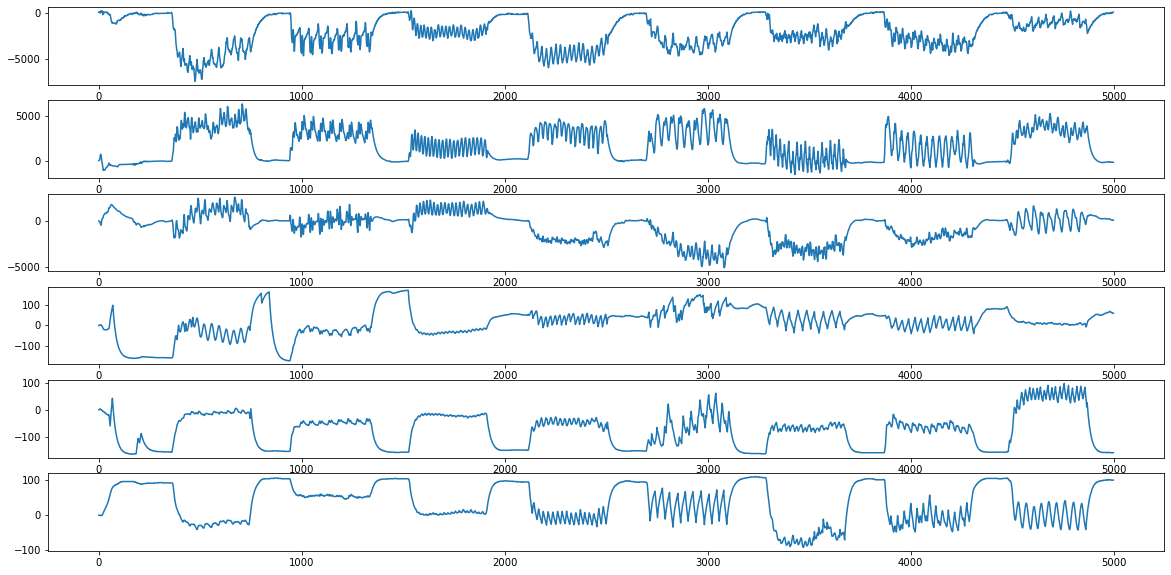

In [17]:
SLICE = slice(0, 5000)
for i in range(0, num_graphs):
    feature[i] = raw_data[i][SLICE]
    
fig, axs = plt.subplots(num_graphs, figsize=(20, 10))

for i in range(0, num_graphs):
        axs[i].plot([x for x in range(0, len(feature[i]))], feature[i])
plt.show()

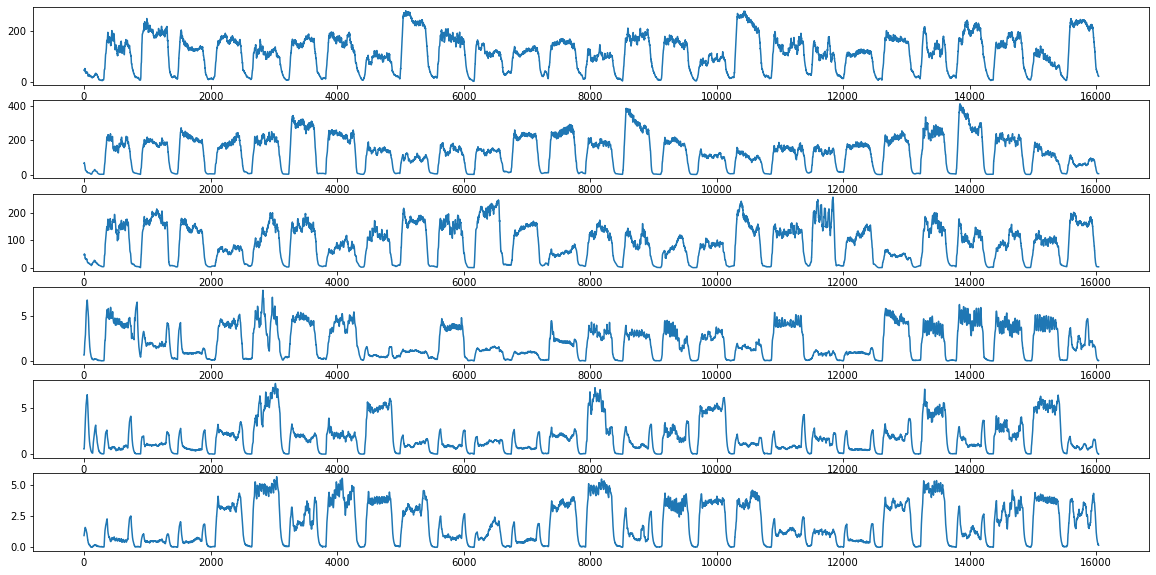

In [4]:
def convolve(arr, w, n):
    if n == 0:
        return arr
    return convolve(np.convolve(arr, np.ones(w), 'valid') / w, w, n - 1)

def rolling_minmax(arr, window_size):
    result = []
    for i in range(0, len(arr) - window_size):
        local_min = min(arr[i: i + window_size])
        local_max = max(arr[i: i + window_size])
        result.append(local_max - local_min)
    
    return result

# rolling mean feature (measure average xyzypr values)
def feature_1(arr):
    arr = convolve(arr, 48 + 1, 1)
    return arr

# rolling minmax feature (measure spike size)
def feature_2(arr, spike_size=150):
    arr = rolling_minmax(arr, 48)
    arr = [spike_size if x > spike_size else x for x in arr]
    return arr

# discrete step filter for ypr (step 2 & 4)
def feature_3(arr, step=2, stability_factor=48):
    if (len(arr) < stability_factor):
        return arr
    arr = np.diff(arr, n=1)
    arr = np.absolute(arr)
    arr = convolve(arr, stability_factor, 1)
    arr = [0 if x < step else x for x in arr]
    return arr

fig, axs = plt.subplots(num_graphs, figsize=(20, 10))

for i in range(0, num_graphs):
    feature[i] = feature_3(raw_data[i], 0)

for i in range(0, num_graphs):
        axs[i].plot([x for x in range(0, len(feature[i]))], feature[i])
plt.show()

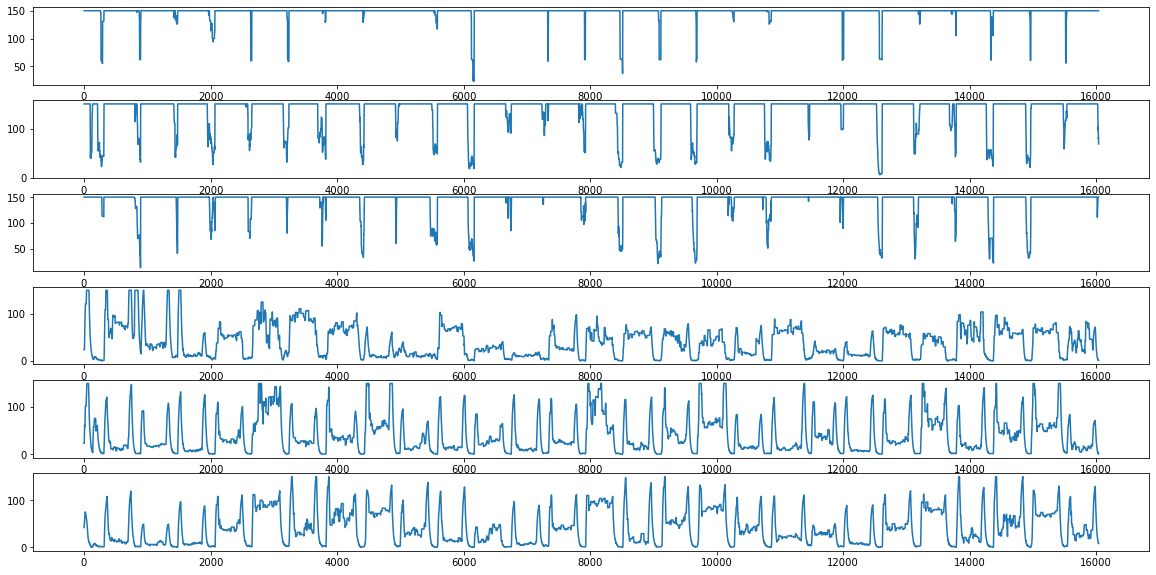

In [5]:
fig, axs = plt.subplots(num_graphs, figsize=(20, 10))

for i in range(0, num_graphs):
    feature[i] = feature_2(raw_data[i])

for i in range(0, num_graphs):
        axs[i].plot([x for x in range(0, len(feature[i]))], feature[i])
plt.show()

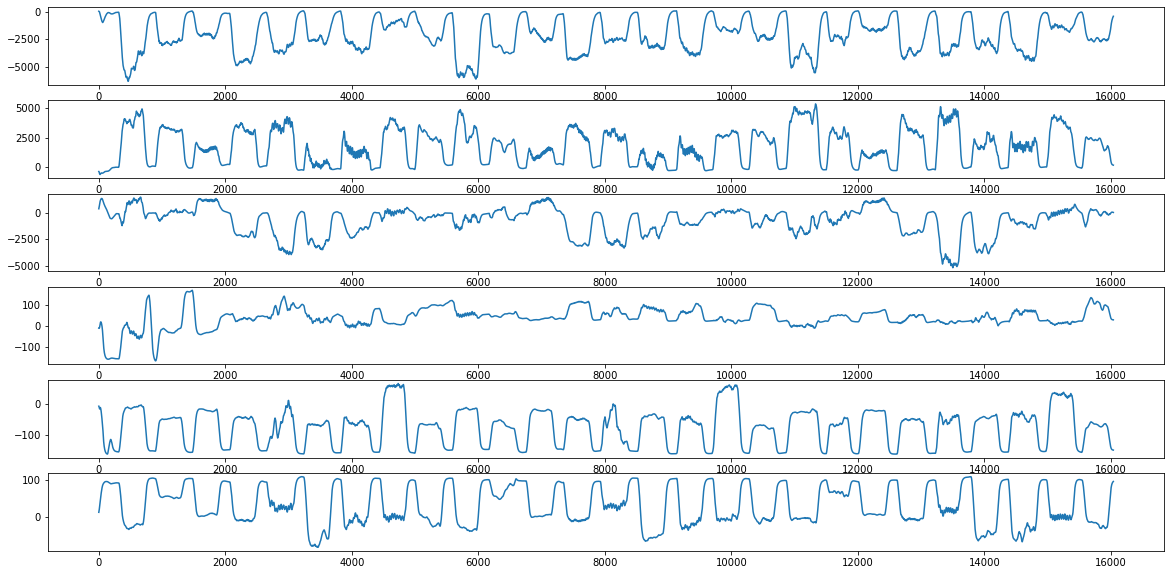

In [6]:
fig, axs = plt.subplots(num_graphs, figsize=(20, 10))

for i in range(0, num_graphs):
    feature[i] = feature_1(raw_data[i])

for i in range(0, num_graphs):
        axs[i].plot([x for x in range(0, len(feature[i]))], feature[i])
plt.show()

In [7]:
final_features = []
final_features.append(feature_1(raw_data[0]))
final_features.append(feature_1(raw_data[1]))
final_features.append(feature_1(raw_data[2]))
final_features.append(feature_1(raw_data[4]))
final_features.append(feature_1(raw_data[5]))
final_features.append(feature_2(raw_data[3], 100))
final_features.append(feature_2(raw_data[4]))
final_features.append(feature_3(raw_data[0], 0))
final_features.append(feature_3(raw_data[1], 0))
final_features.append(feature_3(raw_data[2], 0))
final_features.append(feature_3(raw_data[4], 0))
final_features.append(feature_3(raw_data[5], 0))

from sklearn.preprocessing import StandardScaler

scalers = []
'''
    print(min(a), max(a)-min(a))
    return [(float(i)-min(a))/(max(a)-min(a)) for i in a]
'''
def normalize(arr):
    arr = np.array(arr)
    arr = arr.reshape(-1, 1)
    scaler = StandardScaler()
    scaler.fit(arr)
    scalers.append(scaler)
    return scaler.transform(arr)

    

final_features = [normalize(x) for x in final_features]
for sc in scalers:
    print(str(sc.mean_[0]) + ',')
print('')
for sc in scalers:
    print(str(sc.scale_[0]) + ',')

-2115.534613970284,
1745.0986129472676,
-731.1806362298021,
-74.24628997431007,
31.276243747701713,
39.52484568863395,
39.68763638630838,
114.07980417523952,
132.33187464929236,
90.21077529771183,
1.7870775921192095,
1.8900713365338655,

1528.6806359796387,
1485.3316546967924,
1297.8928765369553,
57.92389451706283,
51.73119557546073,
29.734565552817795,
38.51798709728382,
67.24541300002035,
92.56493343101354,
63.16309455693329,
1.6874139787493947,
1.5788794320350645,


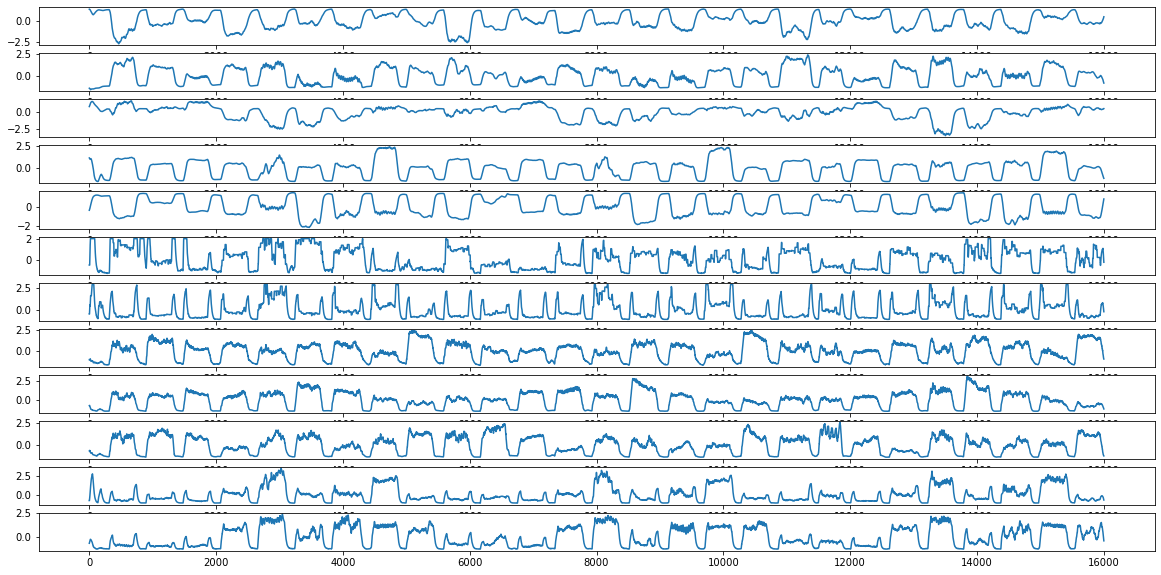

In [8]:
fig, axs = plt.subplots(len(final_features), figsize=(20, 10))

SLICE = slice(0, 16000)

for i in range(0, len(final_features)):
        axs[i].plot([x for x in range(0, len(final_features[i][SLICE]))], final_features[i][SLICE])
plt.show()

In [9]:
import csv

'''         
     dab:  400 - 600   5700 - 5900   11000 - 11200
sidepump: 1000 - 1200  6300 - 6500   11600 - 11800
    wipe: 1600 - 1800  6900 - 7100   12100 - 12300
    hair: 2200 - 2400  7400 - 7600   12700 - 12900
    kick: 2800 - 3000  8000 - 8200   13300 - 13500
   point: 3400 - 3600  8700 - 8900   13900 - 14100
     gun: 3900 - 4100  9200 - 9400   14500 - 14700
  listen: 4600 - 4800  9800 - 10000  15100 - 15300
    roll: 5100 - 5300 10400 - 10600  15700 - 15900
'''

def write_to_file(r, dance_move, prefix):
    with open(f"./data/{dance_move}_{prefix}.csv", "a") as f:
        for i in r:
            x= ''
            for j in range(0, len(final_features)):
                x += str(final_features[j][i][0]) + ','
            x = x[:-1]
            f.write(x + "\n")
    pass       

DAB, SIDEPUMP, WIPE, HAIR, KICK, POINT, GUN, LISTEN, ROLL = 0, 1, 2, 3, 4, 5, 6, 7, 8

write_to_file(range(400, 600), DAB, '3')
write_to_file(range(5700, 5900), DAB, '4')
write_to_file(range(11000, 11200), DAB, '5')
write_to_file(range(1000, 1200), SIDEPUMP, '3')
write_to_file(range(6300, 6500), SIDEPUMP, '4')
write_to_file(range(11600, 11800), SIDEPUMP, '5')
write_to_file(range(1600, 1800), WIPE, '3')
write_to_file(range(6900, 7100), WIPE, '4')
write_to_file(range(12100, 12300), WIPE, '5')
write_to_file(range(2200, 2400), HAIR, '3')
write_to_file(range(7400, 7600), HAIR, '4')
write_to_file(range(12700, 12900), HAIR, '5')
write_to_file(range(2800, 3000), KICK, '3')
write_to_file(range(8000, 8200), KICK, '4')
write_to_file(range(13300, 13500), KICK, '5')
write_to_file(range(3400, 3600), POINT, '3')
write_to_file(range(8700, 8900), POINT, '4')
write_to_file(range(13900, 14100), POINT, '5')
write_to_file(range(3900, 4100), GUN, '3')
write_to_file(range(9200, 9400), GUN, '4')
write_to_file(range(14500, 14700), GUN, '5')
write_to_file(range(4600, 4800), LISTEN, '3')
write_to_file(range(9800, 10000), LISTEN, '4')
write_to_file(range(15100, 15300), LISTEN, '5')
write_to_file(range(5100, 5300), ROLL, '3')
write_to_file(range(10400, 10600), ROLL, '4')
write_to_file(range(15700, 15900), ROLL, '5')

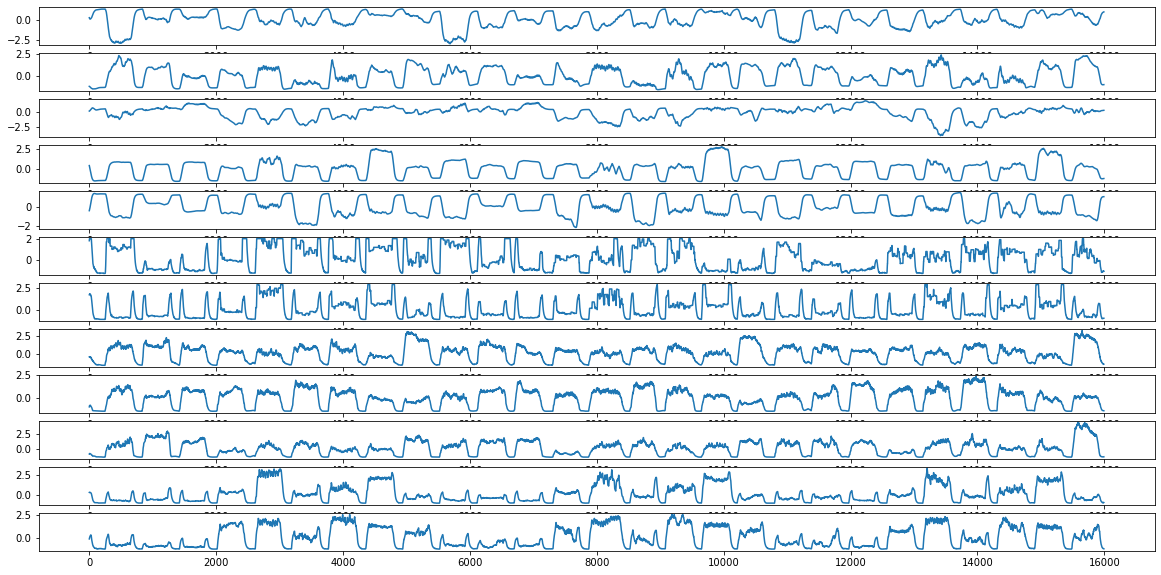

In [10]:
graph_data = open('./bluetooth_data/jeff_1.csv','r').read()
raw_data = [[], [], [], [], [], []]

lines = graph_data.split('\n')
for i in range(0, len(lines)):
    if len(lines[i]) > 1:
        values = lines[i].split(',')
        for j in range(0, 6):
            raw_data[j].append(int(values[j]))
            
final_features = []
final_features.append(feature_1(raw_data[0]))
final_features.append(feature_1(raw_data[1]))
final_features.append(feature_1(raw_data[2]))
final_features.append(feature_1(raw_data[4]))
final_features.append(feature_1(raw_data[5]))
final_features.append(feature_2(raw_data[3], 100))
final_features.append(feature_2(raw_data[4]))
final_features.append(feature_3(raw_data[0], 0))
final_features.append(feature_3(raw_data[1], 0))
final_features.append(feature_3(raw_data[2], 0))
final_features.append(feature_3(raw_data[4], 0))
final_features.append(feature_3(raw_data[5], 0))

for i in range(0, len(final_features)):
    arr = np.array(final_features[i])
    arr = arr.reshape(-1, 1)
    final_features[i] = scalers[i].transform(arr)
    
fig, axs = plt.subplots(len(final_features), figsize=(20, 10))

SLICE = slice(0, 16000)

for i in range(0, len(final_features)):
        axs[i].plot([x for x in range(0, len(final_features[i][SLICE]))], final_features[i][SLICE])
plt.show()

In [11]:
'''         
     dab:  400 - 600   5700 - 5900   10900 - 11100
sidepump: 1000 - 1200  6200 - 6400   11500 - 11700
    wipe: 1600 - 1800  6900 - 7100   12100 - 12300
    hair: 2100 - 2300  7400 - 7600   12700 - 12900
    kick: 2800 - 3000  8000 - 8200   13200 - 13400
   point: 3300 - 3500  8600 - 8800   13900 - 14100
     gun: 3900 - 4100  9200 - 9400   14400 - 14600
  listen: 4500 - 4700  9800 - 10000  15000 - 15200
    roll: 5000 - 5200 10300 - 10500  15600 - 15800
'''


write_to_file(range(400, 600), DAB, '0')
write_to_file(range(5700, 5900), DAB, '1')
write_to_file(range(10900, 11100), DAB, '2')
write_to_file(range(1000, 1200), SIDEPUMP, '0')
write_to_file(range(6200, 6400), SIDEPUMP, '1')
write_to_file(range(11500, 11700), SIDEPUMP, '2')
write_to_file(range(1600, 1800), WIPE, '0')
write_to_file(range(6900, 7100), WIPE, '1')
write_to_file(range(12100, 12300), WIPE, '2')
write_to_file(range(2100, 2300), HAIR, '0')
write_to_file(range(7400, 7600), HAIR, '1')
write_to_file(range(12700, 12900), HAIR, '2')
write_to_file(range(2800, 3000), KICK, '0')
write_to_file(range(8000, 8200), KICK, '1')
write_to_file(range(13200, 13400), KICK, '2')
write_to_file(range(3300, 3500), POINT, '0')
write_to_file(range(8600, 8800), POINT, '1')
write_to_file(range(13900, 14100), POINT, '2')
write_to_file(range(3900, 4100), GUN, '0')
write_to_file(range(9200, 9400), GUN, '1')
write_to_file(range(14400, 14600), GUN, '2')
write_to_file(range(4500, 4700), LISTEN, '0')
write_to_file(range(9800, 10000), LISTEN, '1')
write_to_file(range(15000, 15200), LISTEN, '2')
write_to_file(range(5000, 5200), ROLL, '0')
write_to_file(range(10300, 10500), ROLL, '1')
write_to_file(range(15600, 15800), ROLL, '2')

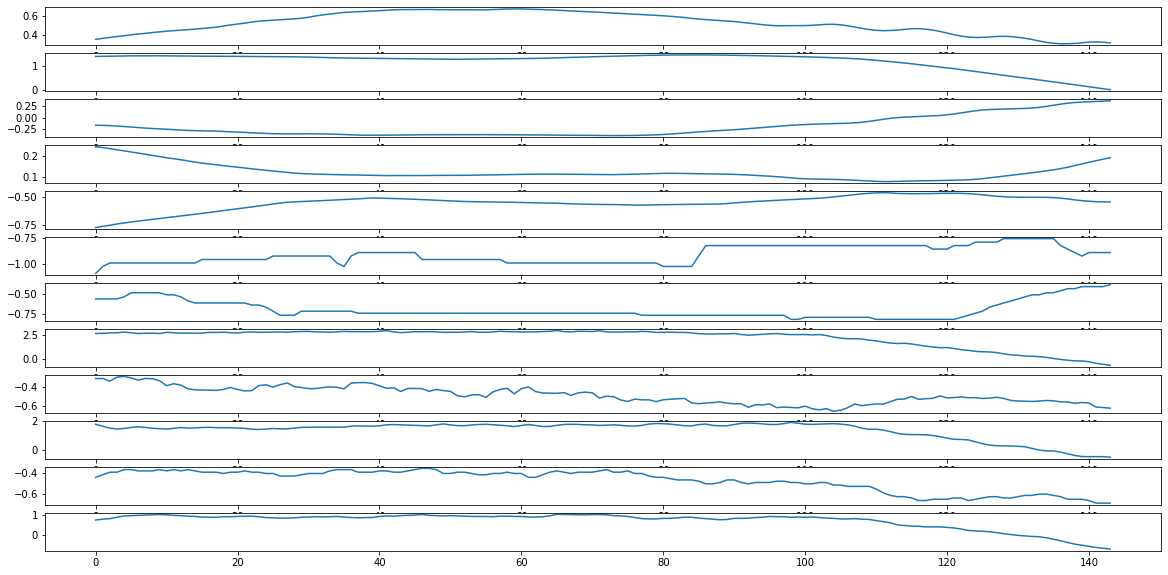

In [12]:
graph_data = open('./bluetooth_data/jeff_4.csv','r').read()
raw_data = [[], [], [], [], [], []]

lines = graph_data.split('\n')
for i in range(0, len(lines)):
    if len(lines[i]) > 1:
        values = lines[i].split(',')
        for j in range(0, 6):
            raw_data[j].append(int(values[j]))
            
final_features = []
final_features.append(feature_1(raw_data[0]))
final_features.append(feature_1(raw_data[1]))
final_features.append(feature_1(raw_data[2]))
final_features.append(feature_1(raw_data[4]))
final_features.append(feature_1(raw_data[5]))
final_features.append(feature_2(raw_data[3], 100))
final_features.append(feature_2(raw_data[4]))
final_features.append(feature_3(raw_data[0], 0))
final_features.append(feature_3(raw_data[1], 0))
final_features.append(feature_3(raw_data[2], 0))
final_features.append(feature_3(raw_data[4], 0))
final_features.append(feature_3(raw_data[5], 0))

for i in range(0, len(final_features)):
    arr = np.array(final_features[i])
    arr = arr.reshape(-1, 1)
    final_features[i] = scalers[i].transform(arr)
    
fig, axs = plt.subplots(len(final_features), figsize=(20, 10))

SLICE = slice(16000, 17000)

for i in range(0, len(final_features)):
        axs[i].plot([x for x in range(0, len(final_features[i][SLICE]))], final_features[i][SLICE])
plt.show()

In [13]:
'''         
     dab:  600 - 800   5900 - 6100   11200 - 11400
sidepump: 1200 - 1400  6400 - 6600   11800 - 12000
    wipe: 1800 - 2000  7000 - 7200   12300 - 12500
    hair: 2400 - 2600  7600 - 7800   12900 - 13100
    kick: 2900 - 3100  8200 - 8400   13500 - 13700
   point: 3500 - 3700  8800 - 9000   14000 - 14200
     gun: 4100 - 4300  9400 - 9600   14600 - 14800
  listen: 4700 - 4900  9900 - 10100  15200 - 15400
    roll: 5300 - 5500 10600 - 10800  15800 - 16000
'''


write_to_file(range(600, 800), DAB, '6')
write_to_file(range(5900, 6100), DAB, '7')
write_to_file(range(11200, 11400), DAB, '8')
write_to_file(range(1200, 1400), SIDEPUMP, '6')
write_to_file(range(6400, 6600), SIDEPUMP, '7')
write_to_file(range(11800, 12000), SIDEPUMP, '8')
write_to_file(range(1800, 2000), WIPE, '6')
write_to_file(range(7000, 7200), WIPE, '7')
write_to_file(range(12300, 12500), WIPE, '8')
write_to_file(range(2400, 2600), HAIR, '6')
write_to_file(range(7600, 7800), HAIR, '7')
write_to_file(range(12900, 13100), HAIR, '8')
write_to_file(range(2900, 3100), KICK, '6')
write_to_file(range(8200, 8400), KICK, '7')
write_to_file(range(13500, 13700), KICK, '8')
write_to_file(range(3500, 3700), POINT, '6')
write_to_file(range(8800, 9000), POINT, '7')
write_to_file(range(14000, 14200), POINT, '8')
write_to_file(range(4100, 4300), GUN, '6')
write_to_file(range(9400, 9600), GUN, '7')
write_to_file(range(14600, 14800), GUN, '8')
write_to_file(range(4700, 4900), LISTEN, '6')
write_to_file(range(9900, 10100), LISTEN, '7')
write_to_file(range(15200, 15400), LISTEN, '8')
write_to_file(range(5300, 5500), ROLL, '6')
write_to_file(range(10600, 10800), ROLL, '7')
write_to_file(range(15800, 16000), ROLL, '8')